In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
class Kernel:
    """Implements a Radial Basis Function (RBF) kernel."""
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        """Calculates the kernel value between two vectors or sets of vectors."""
        x = np.asarray(x)
        y = np.asarray(y)

        if x.ndim == 1 and y.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(x - y)**2)
        elif x.ndim == 2 and y.ndim == 2:
            # Calculate pairwise squared Euclidean distances using broadcasting
            # (x_i - y_j)^2 = x_i^2 - 2*x_i*y_j + y_j^2
            x_sq = np.sum(x**2, axis=1, keepdims=True)
            y_sq = np.sum(y**2, axis=1, keepdims=True).T
            pairwise_sq_dist = x_sq - 2 * x @ y.T + y_sq
            return np.exp(-self.gamma * pairwise_sq_dist)
        else:
            raise ValueError("Inputs to kernel must be 1D or 2D arrays.")


class TestStatistic:
    """Calculates the test statistic T_n,alpha."""
    def __init__(self, alpha=0.5, kernel=None):
        self.alpha = alpha
        # Initialize kernel here with the provided gamma
        if kernel is None:
            self.kernel = Kernel() # Default gamma if not provided
        else:
            self.kernel = kernel

    def __call__(self, X, Y):
        """
        Calculates the T_n,alpha statistic for a given set of pairs (X_i, Y_i).
        Z is a list of tuples, where each tuple is (X_i, Y_i).
        """

        n = len(X)

        # Calculate kernel matrices
        K_XX = self.kernel(X, X)
        K_XY = self.kernel(X, Y)
        K_YX = self.kernel(Y, X)
        K_YY = self.kernel(Y, Y)

        # Calculate the H matrix
        H_matrix = K_XX - K_XY - K_YX + K_YY

        # Extract the lower triangle (excluding the diagonal)
        lower_triangle_H = np.tril(H_matrix, k=-1)

        # Calculate the weights (i+1)^-alpha for i from 1 to n-1
        # The rows of the lower triangle correspond to i from 1 to n-1
        weights = (np.arange(2, n + 1).astype(float)**(-self.alpha)).reshape(-1, 1)

        # Sum the lower triangle along the columns to get Sum_{j=0 to i-1} H_ij for each i
        sum_H_j = np.sum(lower_triangle_H, axis=1)

        # The indices for sum_H_j correspond to i from 0 to n-1. We need i from 1 to n-1
        # so we take sum_H_j[1:]

        # Calculate the weighted sum
        numerator = np.sum(sum_H_j[1:] * weights.flatten())
        denominator = np.sqrt(np.sum((sum_H_j[1:] * weights.flatten())**2))


        return numerator / denominator

In [3]:
def run_permutation_test(X, Y, n_sample, num_permutations=1000, alpha=0.5, gamma=0.1):
    """
    Performs a two-sample permutation test using the T_n,alpha statistic.
    Z_odd and Z_even are the two samples of (X, Y) pairs.
    """

    test_statistic = TestStatistic(alpha=alpha, kernel=Kernel(gamma=gamma))

    # Calculate the observed statistic
    T_observed = test_statistic(X, Y)
    pooled_XY = np.concatenate((X, Y))

    T_permutations = []

    for _ in range(num_permutations):

        # Permute the pooled data
        permuted_XY_list = np.random.permutation(pooled_XY)

        X_permuted = permuted_XY_list[:n_sample]
        Y_permuted = permuted_XY_list[n_sample:]

        # Calculate the statistic for the permuted samples
        T_permuted = test_statistic(X_permuted, Y_permuted)
        T_permutations.append(T_permuted)

    T_permutations = np.array(T_permutations)

    # Calculate the p-value
    p_value = (np.sum(T_permutations >= T_observed) + 1) / (num_permutations + 1)

    return T_observed, p_value

In [4]:
def run_empirical_power_experiment(alpha_value, first_digits, second_digits,
                                   significance_level = 0.05, n_sample_size=100, num_permutations=1000, num_runs=100):
    """
    Runs the permutation test experiment multiple times to calculate empirical power.

    Args:
        alpha_value (float): The significance level for the permutation test.
        first_digits (list): A list of digits for the first group.
        second_digits (list): A list of digits for the second group.
        n_sample_size (int): The size of the sample to draw from each group.
        num_permutations (int): The number of permutations to use in the permutation test.
        num_runs (int): The number of times to run the experiment.

    Returns:
        float: The calculated empirical power.
    """
    p_values = []

    X_all = X[np.isin(y, first_digits)]
    Y_all = X[np.isin(y, second_digits)]

    # Ensure sample sizes are within bounds
    n_sample_size = min(X_all.shape[0], Y_all.shape[0], n_sample_size)


    for run in tqdm(range(num_runs)):
        # Sample n many X from first_digits and n many Y from second_digits
        X_sample = X_all[np.random.choice(X_all.shape[0], n_sample_size, replace=True)]
        Y_sample = Y_all[np.random.choice(Y_all.shape[0], n_sample_size, replace=True)]
        pooled_XY = np.concatenate((X_sample, Y_sample))

        # Compute median heuristic by computing median of pairwise distance for the pooled sample (X, Y)
        diff = pooled_XY[:, np.newaxis] - pooled_XY
        pairwise_sq_dist = np.sum(diff**2, axis=2)
        pairwise_distances_Z = np.sqrt(pairwise_sq_dist).flatten()

        non_zero_distances_Z = pairwise_distances_Z[pairwise_distances_Z > 1e-6]
        median_bandwidth_Z = np.median(non_zero_distances_Z)
        gamma_value = 1.0 / (2 * median_bandwidth_Z**2) # Common heuristic

        # Run the permutation test
        T_observed, p_value = run_permutation_test(X_sample, Y_sample, n_sample_size, num_permutations, alpha=alpha_value, gamma=gamma_value)
        p_values.append(p_value)

    # Calculate empirical power
    empirical_power = np.sum(np.array(p_values) < significance_level) / num_runs

    return empirical_power

In [5]:
# Load the MNIST dataset
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist.data.astype('float32'), mnist.target.astype('int')

# Normalize pixel values
X /= 255.0

Loading MNIST data...


In [6]:
digit_group_pairs = [
    ([2, 4, 8, 9], [3, 4, 7, 9]),
    ([1, 2, 4, 8, 9], [1, 3, 4, 7, 9]),
    ([0, 1, 2, 4, 8, 9], [0, 1, 3, 4, 7, 9]),
    ([0, 1, 2, 4, 5, 8, 9], [0, 1, 3, 4, 5, 7, 9]),
    ([0, 1, 2, 4, 5, 6, 8, 9], [0, 1, 3, 4, 5, 6, 7, 9])
]

alpha_values_range = np.array([0, 0.25, 0.5, 0.75, 1]) # Alpha values from 0.1 to 0.9

In [7]:
# Power

np.random.seed(42)
results_mean = {}
results_std = {}
num_outer_runs = 25 # Number of times to repeat the experiment for mean and std

print("Running empirical power experiment for different digit group pairs and alpha values...")
for first_digits_group, second_digits_group in digit_group_pairs:

    group_pair_key = f"Group1: {first_digits_group}, Group2: {second_digits_group}"
    results_mean[group_pair_key] = {}
    results_std[group_pair_key] = {}
    print(f"\nRunning for group pair: {group_pair_key}")

    for alpha in alpha_values_range:
        print(f"Running for alpha = {alpha:.2f}")
        empirical_powers = []
        for outer_run in range(num_outer_runs):
            power = run_empirical_power_experiment(alpha_value=alpha,
                                                   first_digits=first_digits_group,
                                                   second_digits=second_digits_group,
                                                   significance_level=0.05,
                                                   n_sample_size=100,
                                                   num_permutations=100,
                                                   num_runs=100)
            empirical_powers.append(power)

        mean_power = np.mean(empirical_powers)
        std_power = np.std(empirical_powers)
        results_mean[group_pair_key][alpha] = mean_power
        results_std[group_pair_key][alpha] = std_power

        print(f"Empirical Power (Mean) = {mean_power:.4f}, Std Dev = {std_power:.4f}")


print("\nEmpirical power calculations finished for all group pairs and alpha values.")

Running empirical power experiment for different digit group pairs and alpha values...

Running for group pair: Group1: [2, 4, 8, 9], Group2: [3, 4, 7, 9]
Running for alpha = 0.00


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Empirical Power (Mean) = 1.0000, Std Dev = 0.0000
Running for alpha = 0.25


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Empirical Power (Mean) = 1.0000, Std Dev = 0.0000
Running for alpha = 0.50


100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


Empirical Power (Mean) = 1.0000, Std Dev = 0.0000
Running for alpha = 0.75


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Empirical Power (Mean) = 1.0000, Std Dev = 0.0000
Running for alpha = 1.00


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Empirical Power (Mean) = 0.9992, Std Dev = 0.0039

Running for group pair: Group1: [1, 2, 4, 8, 9], Group2: [1, 3, 4, 7, 9]
Running for alpha = 0.00


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Empirical Power (Mean) = 0.9940, Std Dev = 0.0080
Running for alpha = 0.25


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Empirical Power (Mean) = 0.9944, Std Dev = 0.0085
Running for alpha = 0.50


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


Empirical Power (Mean) = 0.9912, Std Dev = 0.0077
Running for alpha = 0.75


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Empirical Power (Mean) = 0.9824, Std Dev = 0.0095
Running for alpha = 1.00


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Empirical Power (Mean) = 0.9516, Std Dev = 0.0199

Running for group pair: Group1: [0, 1, 2, 4, 8, 9], Group2: [0, 1, 3, 4, 7, 9]
Running for alpha = 0.00


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


Empirical Power (Mean) = 0.9204, Std Dev = 0.0252
Running for alpha = 0.25


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Empirical Power (Mean) = 0.9256, Std Dev = 0.0284
Running for alpha = 0.50


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Empirical Power (Mean) = 0.9088, Std Dev = 0.0337
Running for alpha = 0.75


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Empirical Power (Mean) = 0.8772, Std Dev = 0.0293
Running for alpha = 1.00


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Empirical Power (Mean) = 0.7916, Std Dev = 0.0442

Running for group pair: Group1: [0, 1, 2, 4, 5, 8, 9], Group2: [0, 1, 3, 4, 5, 7, 9]
Running for alpha = 0.00


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Empirical Power (Mean) = 0.8076, Std Dev = 0.0386
Running for alpha = 0.25


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Empirical Power (Mean) = 0.8052, Std Dev = 0.0341
Running for alpha = 0.50


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Empirical Power (Mean) = 0.7952, Std Dev = 0.0347
Running for alpha = 0.75


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Empirical Power (Mean) = 0.7436, Std Dev = 0.0433
Running for alpha = 1.00


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Empirical Power (Mean) = 0.6272, Std Dev = 0.0362

Running for group pair: Group1: [0, 1, 2, 4, 5, 6, 8, 9], Group2: [0, 1, 3, 4, 5, 6, 7, 9]
Running for alpha = 0.00


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Empirical Power (Mean) = 0.6456, Std Dev = 0.0475
Running for alpha = 0.25


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Empirical Power (Mean) = 0.6460, Std Dev = 0.0410
Running for alpha = 0.50


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


Empirical Power (Mean) = 0.6344, Std Dev = 0.0403
Running for alpha = 0.75


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Empirical Power (Mean) = 0.5908, Std Dev = 0.0523
Running for alpha = 1.00


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]

Empirical Power (Mean) = 0.4992, Std Dev = 0.0475

Empirical power calculations finished for all group pairs and alpha values.


In [8]:
import pickle

# Save the results
with open('power_results_mean.pkl', 'wb') as f:
    pickle.dump(results_mean, f)

with open('power_results_std.pkl', 'wb') as f:
    pickle.dump(results_std, f)

print("Results saved to power_results_mean.pkl and power_results_std.pkl")

Results saved to power_results_mean.pkl and power_results_std.pkl


In [9]:
import pickle

# Load the results
with open('power_results_mean.pkl', 'rb') as f:
    loaded_results_mean = pickle.load(f)

with open('power_results_std.pkl', 'rb') as f:
    loaded_results_std = pickle.load(f)

print("Results loaded successfully.")

Results loaded successfully.


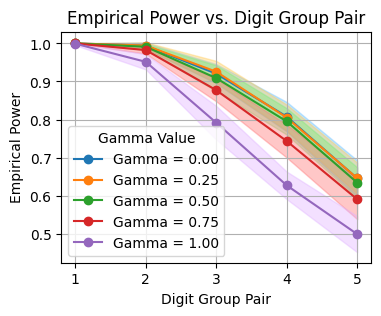

In [10]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data_mean = {}
plot_data_std = {}
for alpha in alpha_values_range:
    plot_data_mean[alpha] = []
    plot_data_std[alpha] = []
    for group_pair_key in loaded_results_mean.keys(): # Use loaded_results_mean and loaded_results_std
        plot_data_mean[alpha].append(loaded_results_mean[group_pair_key][alpha])
        plot_data_std[alpha].append(loaded_results_std[group_pair_key][alpha])


# Create the plot
plt.figure(figsize=(4, 3))
group_labels = [str(i+1) for i in range(len(digit_group_pairs))]

# Get a colormap with distinct colors for categorical data
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(alpha_values_range))]

for i, alpha in enumerate(alpha_values_range):
    mean_values = np.array(plot_data_mean[alpha])
    std_values = np.array(plot_data_std[alpha])
    line_color = colors[i]
    # Create a lighter shade of the line color
    lighter_color = tuple(min(c + 0.3, 1) for c in line_color[:3]) + (0.4,) # Increase brightness and set alpha

    plt.plot(group_labels, mean_values, marker='o', linestyle='-', color=line_color, label=f'Gamma = {alpha:.2f}')
    plt.fill_between(group_labels, mean_values - std_values, mean_values + std_values, color=lighter_color, alpha=0.4)


plt.xlabel("Digit Group Pair")
plt.ylabel("Empirical Power")
plt.title("Empirical Power vs. Digit Group Pair")
plt.legend(title="Gamma Value")
plt.grid(True)

# Save the plot as a PDF
plt.savefig("empirical_power_plot.pdf", bbox_inches='tight')

plt.show()